<a href="https://colab.research.google.com/github/q1mora/cnt-property-prediction-using-ml-architectures/blob/ml/chirality_kans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
!pip install pykan
from kan import KAN
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 3.8 MB/s eta 0:00:00


In [ ]:
# configuration
seed = 43
np.random.seed(seed)
torch.manual_seed(seed)
batch_size = 32
num_epochs = 100
learning_rate = 0.001

In [ ]:
# data loading and feature engineering

data = pd.read_csv('chirality_indices_data - Sheet1.csv')


data['n_m_mod_3'] = data['n_minus_m'] % 3
data = pd.get_dummies(data, columns=['n_m_mod_3'], prefix='mod').astype(int)

print("data head after one-hot encoding:")
print(data.head())

# define features (x) and target (y)
features = ['mod_0', 'mod_1', 'mod_2']
target = 'metallicity'

x = data[features].values
y = data[target].values

# train test split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=seed, stratify=y
)

data head after one-hot encoding:
     n    m  n_minus_m  modulus  metallicity  mod_0  mod_1  mod_2
0  104    1        103        2            1      0      1      0
1  244  133        111        0            0      1      0      0
2  210  115         95        2            1      0      0      1
3  222  177         45        0            0      1      0      0
4  152   26        126        0            0      1      0      0



generating data distribution plots...
saved 'distribution_train.png'
Saved 'distribution_test.png'


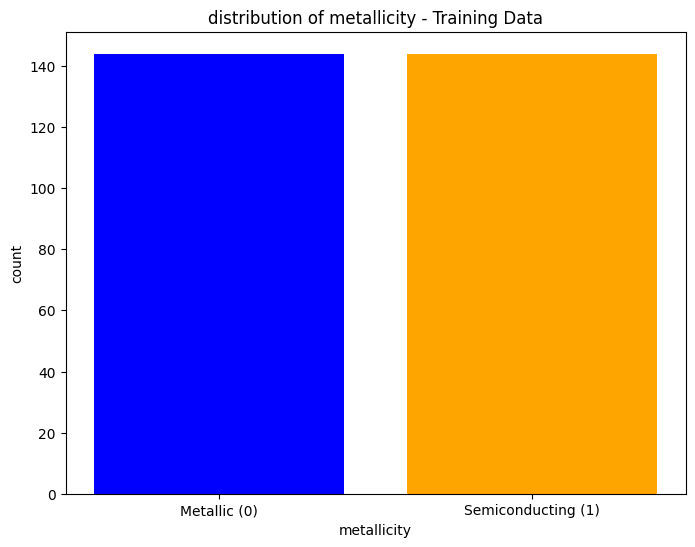

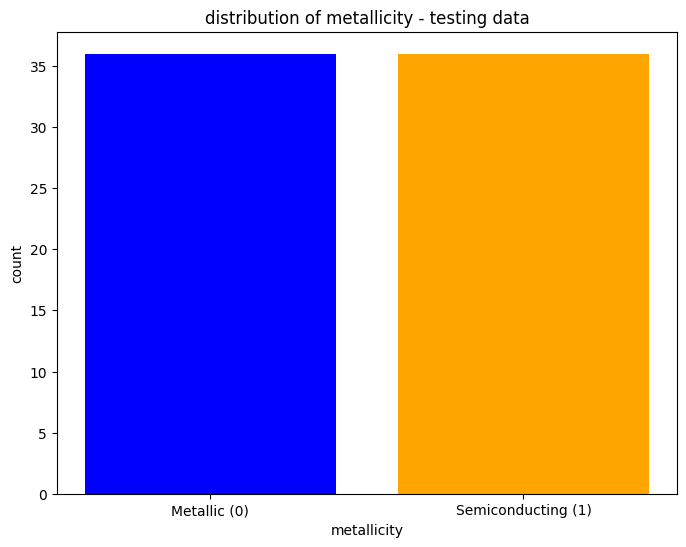

In [ ]:
# plotting data distributions
print("\ngenerating data distribution plots...")
# Plot training data distribution
unique_train, counts_train = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_train.astype(str), counts_train, color=['blue', 'orange'])
plt.xticks(unique_train, ['Metallic (0)', 'Semiconducting (1)'])
plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of metallicity - Training Data')
plt.savefig('distribution_train.png')
print("saved 'distribution_train.png'")

# plot testing data distribution
unique_test, counts_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_test.astype(str), counts_test, color=['blue', 'orange'])
plt.xticks(unique_test, ['Metallic (0)', 'Semiconducting (1)'])
plt.xlabel('metallicity')
plt.ylabel('count')
plt.title('distribution of metallicity - testing data')
plt.savefig('distribution_test.png')
print("Saved 'distribution_test.png'")



In [ ]:
# convert to pytorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# define the KAN model
model = KAN(width=[3, 5, 1], grid=5, k=3, seed=seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

checkpoint directory created: ./model
saving model version 0.0

Using device: cuda


In [ ]:
# training loop
print('start training')
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
end_time = time.time()

print('training finished')
total_training_time = end_time - start_time
print(f'total training time: {total_training_time:.2f} seconds')

# testing and evaluation
print('\nstart testing')
model.eval()
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        predicted = torch.round(torch.sigmoid(outputs))
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())


start training
epoch [10/100], Loss: 0.5860
epoch [20/100], Loss: 0.3400
epoch [30/100], Loss: 0.1412
epoch [40/100], Loss: 0.0591
epoch [50/100], Loss: 0.0267
epoch [60/100], Loss: 0.0157
epoch [70/100], Loss: 0.0093
epoch [80/100], Loss: 0.0067
epoch [90/100], Loss: 0.0047
epoch [100/100], Loss: 0.0034
training finished
total training time: 26.74 seconds

start testing


accuracy of the model on the test samples: 100.00 %

classification report
                    precision    recall  f1-score   support

      Metallic (0)       1.00      1.00      1.00        36
Semiconducting (1)       1.00      1.00      1.00        36

          accuracy                           1.00        72
         macro avg       1.00      1.00      1.00        72
      weighted avg       1.00      1.00      1.00        72


generating final plots
saved 'confusion_matrix_kan.png'
saving KAN spline plots to 'kan_spline_plots' directory...
plots saved.


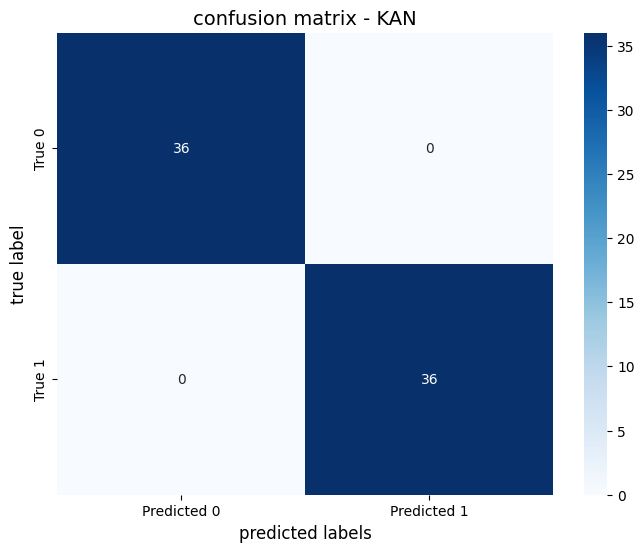

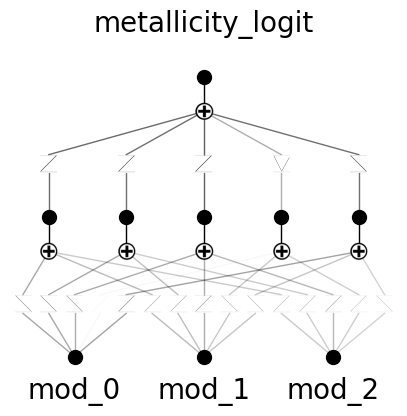

In [ ]:
# printing results
y_true = np.array(y_true_list).ravel()
y_pred = np.array(y_pred_list).ravel()

accuracy = accuracy_score(y_true, y_pred)
print(f'accuracy of the model on the test samples: {accuracy*100:.2f} %\n')
target_names = ['Metallic (0)', 'Semiconducting (1)']
report = classification_report(y_true, y_pred, target_names=target_names)
print('classification report')
print(report)

# confusion matrix and KAN splines
print("\ngenerating final plots")
# plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['True 0', 'True 1'])
plt.xlabel('predicted labels', fontsize=12)
plt.ylabel('true label', fontsize=12)
plt.title('confusion matrix - KAN', fontsize=14)
plt.savefig('confusion_matrix_kan.png')
print("saved 'confusion_matrix_kan.png'")

# plot KAN splines
# this will create a folder and save the spline plots inside it
kan_plot_folder = 'kan_spline_plots'
print(f"saving KAN spline plots to '{kan_plot_folder}' directory...")
if not os.path.exists(kan_plot_folder):
    os.makedirs(kan_plot_folder)
# we set the feature names so the plots are clearly labeled
model.plot(folder=kan_plot_folder, in_vars=['mod_0', 'mod_1', 'mod_2'], out_vars=['metallicity_logit'])
print("plots saved.")